In [ ]:
!nvidia-smi

## 1) Installing libraries

In [ ]:
!pip install transformers
!pip install datasets
!pip install wandb

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset, Dataset

## 2) Loading dataset (from HF)


In [ ]:
# enter your personal read token

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from datasets import load_dataset

aggression_dataset = load_dataset("IIIT-L/twitter_election_scrapped", use_auth_token=True)

print(aggression_dataset)

In [ ]:
train_ds = aggression_dataset['train']
train_ds

## 3) Converting to dataframe

In [ ]:
aggression_dataset.set_format(type='pandas')
train_df = aggression_dataset['train'][:]
valid_df = aggression_dataset['validation'][:]

train_df.head()

In [ ]:
test_df = aggression_dataset['test'][:]

In [ ]:
train_df['Label'].value_counts()

In [ ]:
# 1599
# NAG-CAG-OAG (0-1-2) = 0.50-0.26-0.24

Seeing Distribution

In [ ]:
disb_df = train_df.copy(deep=True)

In [ ]:
disb_df['Words per sentence'] = disb_df['Sentence'].str.split().apply(len)
disb_df.boxplot('Words per sentence', by='Label', grid=False, showfliers=False, color='black')
plt.suptitle("")
plt.xlabel("")
plt.show()

## 4) Tokenizing

In [ ]:
from transformers import AutoTokenizer

In [ ]:
model_ckpt = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [ ]:
tokenizer.vocab_size

30522

In [ ]:
train_texts = list(train_df['Sentence'])
train_labels = list(train_df['Label'])

In [ ]:
valid_texts = list(valid_df['Sentence'])
valid_labels = list(valid_df['Label'])

## 5) Encoding train-valid

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
valid_encodings = tokenizer(valid_texts, truncation=True, padding=True)

In [ ]:
import torch

class AggressionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = AggressionDataset(train_encodings, train_labels)
valid_dataset = AggressionDataset(valid_encodings, valid_labels)

## 6) Setting classification model and evaluation metrics

In [ ]:
import torch

In [ ]:
# Use in case of CUDA memory error

# import gc

# gc.collect()
# torch.cuda.empty_cache()

In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

def model_init():
    model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels))
    return model

cuda


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, plot_confusion_matrix

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)

  f1 = f1_score(labels, preds, average='macro')
  precision = precision_score(labels, preds, average='macro')
  recall = recall_score(labels, preds, average='macro')
  acc = accuracy_score(labels, preds)
  return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

## 7) Fine-tuning, visualizing training, saving model to HF  

In [ ]:
import wandb

wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
%env WANDB_PROJECT = aggression_detection

env: WANDB_PROJECT=aggression_detection


In [ ]:
from transformers import Trainer, TrainingArguments

In [ ]:
# Defining hyperparameters
eval_batch_size = 16
logging_steps = len(train_texts) // eval_batch_size
model_name = f"{model_ckpt}-finetuned-ours-DS"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=6,
                                  learning_rate=4.1187640010910775e-05,
                                  per_device_train_batch_size=8,
                                  per_device_eval_batch_size=16,
                                  weight_decay=0.13668695797323277,
                                  evaluation_strategy='steps',
                                  save_strategy='steps',
                                  max_steps=-1,
                                  warmup_ratio=0.0,
                                  seed=43,
                                  data_seed=4,
                                  metric_for_best_model="eval_f1",
                                  greater_is_better=True,
                                  load_best_model_at_end=True, 
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  save_steps=logging_steps,
                                  log_level='info', 
                                  report_to="wandb", 
                                  run_name="roberta-ours-DS",
                                  push_to_hub=True)

In [ ]:
# import gc

# gc.collect()
# torch.cuda.empty_cache()

In [ ]:
from torch import nn

class CustomTrainer(Trainer):
  def compute_loss(self, model, inputs, return_outputs=False):
    device = torch.device('cuda')
    inputs.to(device)
    labels = inputs.get("labels")
    # forward pass
    outputs = model(**inputs)
    logits = outputs.get("logits")
    # compute custom loss (suppose one has 3 labels with different weights)
    loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([0.22, 0.27, 0.51]).to(device))
    loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

In [ ]:
from transformers import EarlyStoppingCallback

In [ ]:
# enter your personal write token here

from huggingface_hub import notebook_login
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [ ]:
trainer = CustomTrainer(model_init=model_init,
                        args=training_args,
                        compute_metrics = compute_metrics,
                        train_dataset = train_dataset,
                        eval_dataset = valid_dataset,
                        tokenizer = tokenizer, 
                        callbacks = [EarlyStoppingCallback(early_stopping_patience = 2, early_stopping_threshold=0.0001)]
)

trainer.train()

# post-training analysis, testing, other logged code
wandb.finish()

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_

wandb: Currently logged in as: sky-s-the-limit. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
99,0.978400,0.809430,0.605000,0.386530,0.527658,0.442042
198,0.819600,0.787978,0.635000,0.695791,0.590562,0.522516
297,0.595000,0.834573,0.720000,0.685830,0.658307,0.662291
396,0.553600,0.720585,0.680000,0.670050,0.648254,0.614870
495,0.273700,1.331163,0.705000,0.695833,0.678150,0.667701
594,0.297900,1.222890,0.715000,0.686243,0.667409,0.669501
693,0.099900,1.478932,0.730000,0.694051,0.681339,0.684519
792,0.114900,1.615936,0.720000,0.684447,0.671561,0.674737
891,0.057500,1.625612,0.720000,0.691760,0.683734,0.682146


***** Running Evaluation *****
  Num examples = 200
  Batch size = 16
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Saving model checkpoint to bert-base-uncased-finetuned-ours-DS/checkpoint-99
Configuration saved in bert-base-uncased-finetuned-ours-DS/checkpoint-99/config.json
Model weights saved in bert-base-uncased-finetuned-ours-DS/checkpoint-99/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-finetuned-ours-DS/checkpoint-99/tokenizer_config.json
Special tokens file saved in bert-base-uncased-finetuned-ours-DS/checkpoint-99/special_tokens_map.json
tokenizer config file saved in bert-base-uncased-finetuned-ours-DS/tokenizer_config.json
Special tokens file saved in bert-base-uncased-finetuned-ours-DS/special_tokens_map.

eval/accuracy,▁▃▇▅▇▇█▇▇
eval/f1,▁▃▇▆█████
eval/loss,▂▂▂▁▆▅▇██
eval/precision,▁██▇█████
eval/recall,▁▄▇▆█▇█▇█
eval/runtime,▁▃▆▅█▇█▇▇
eval/samples_per_second,█▆▃▄▁▂▁▂▂
eval/steps_per_second,█▆▃▄▁▂▁▂▂
train/epoch,▁▁▂▂▃▃▄▄▅▅▅▅▆▆▇▇███
train/global_step,▁▁▂▂▃▃▄▄▅▅▅▅▆▆▇▇███
train/learning_rate,█▇▆▅▄▄▃▂▁


In [ ]:
trainer.push_to_hub()

Saving model checkpoint to bert-base-uncased-finetuned-ours-DS
Configuration saved in bert-base-uncased-finetuned-ours-DS/config.json
Model weights saved in bert-base-uncased-finetuned-ours-DS/pytorch_model.bin
tokenizer config file saved in bert-base-uncased-finetuned-ours-DS/tokenizer_config.json
Special tokens file saved in bert-base-uncased-finetuned-ours-DS/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.34k/418M [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/SkyR/bert-base-uncased-finetuned-ours-DS
   7312e00..96c75d3  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/SkyR/bert-base-uncased-finetuned-ours-DS
   7312e00..96c75d3  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.72}, {'name': 'Precision', 'type': 'precision', 'value': 0.691759702286018}, {'name': 'Recall', 'type': 'recall', 'value': 0.6837342551628266}, {'name': 'F1', 'type': 'f1', 'value': 0.6821464690589276}]}
To https://huggingface.co/SkyR/bert-base-uncased-finetuned-ours-DS
   96c75d3..d5f6178  main -> main

   96c75d3..d5f6178  main -> main



'https://huggingface.co/SkyR/bert-base-uncased-finetuned-ours-DS/commit/96c75d3861eac4b16f9f1d6c6bf32be79500ae6f'

## 8) Predictions and Results

In [ ]:
test_texts = list(test_df['Sentence'])
test_labels = list(test_df['Label'])

In [ ]:
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [ ]:
test_dataset = AggressionDataset(test_encodings, test_labels)

In [ ]:
preds_output_test = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 200
  Batch size = 16


In [ ]:
preds_output_test.metrics

{'test_loss': 1.6370785236358643,
 'test_accuracy': 0.685,
 'test_precision': 0.6606518982621019,
 'test_recall': 0.6381739953168525,
 'test_f1': 0.6468535277358806,
 'test_runtime': 1.0665,
 'test_samples_per_second': 187.533,
 'test_steps_per_second': 12.19}

In [ ]:
y_preds_test = np.argmax(preds_output_test.predictions, axis=1)

In [ ]:
y_valid_test = np.array(test_dataset.labels)

In [ ]:
map_dt = {0:'NAG', 1:'CAG', 2:'OAG'}

In [ ]:
print(classification_report(y_valid_test, y_preds_test, target_names=list(map_dt.values())))

              precision    recall  f1-score   support

         NAG       0.76      0.84      0.80        99
         CAG       0.44      0.42      0.43        52
         OAG       0.78      0.65      0.71        49

    accuracy                           0.69       200
   macro avg       0.66      0.64      0.65       200
weighted avg       0.68      0.69      0.68       200



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_valid_trying = map(lambda x : map_dt[x], y_valid_test)
y_valid_trying = list(y_valid_trying)

y_preds_trying = map(lambda x : map_dt[x], y_preds_test)
y_preds_trying = list(y_preds_trying)

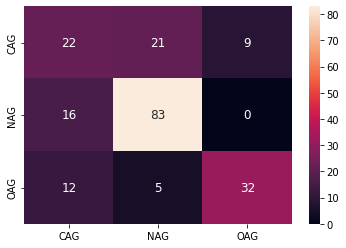

In [ ]:
cm_labels = np.unique(y_valid_trying)
cm_array = confusion_matrix(y_valid_trying, y_preds_trying)
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)
sns.heatmap(cm_array_df, annot=True, annot_kws={"size": 12}) 